# Skeleton Threat Detection

In [1]:
import time
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

# Part 1: Load Data

In [2]:
# set relevant skeletal indexes in the desired order with labels. Create array for skeletons with confidence flag
rele_dexes = [12,11,10,2,13,14,15,3,7,6,8,9,-1]
joint_names = ['R Shoulder','R Elbow','R Wrist','R Hip','L Shoulder','L Elbow','L Hand','L Hip','Chest','Pelvis','Neck','Pate','Gun']
conf_flag = 1   # should be 0 or 1
x = np.empty((1,len(rele_dexes),2+conf_flag))
y = []

# set indexes for normalization 
right_elbow = 8
right_wrist = 10
l_shoulder = 5
r_shoulder = 6

#set folders and labels for each folder (0=high,1=medium,2=low)
folders = ["skeleton_threat/1_high/skeletons/", "skeleton_threat/2_medium/skeletons/", "skeleton_threat/3_mild/skeletons/", "skeleton_threat/4_low/skeletons/"]
threats = [0,1,2,2]

#read skeletons into array and create labels
last_count = 0
for folder in range(len(folders)):
    for f in listdir(folders[folder]):
        skele = np.load(folders[folder]+f)    #read skeletons
        skele[-1][-1] = 1  #reset gun confidence which is always 0 in given files
        if skele[rele_dexes].all() > .0001:     #only include skeletons with all joints
            skele[:,0:2] -= skele[right_elbow,0:2]     #normalize to right elbow with elbow to wrist=1
            forearm_len = np.sqrt(skele[right_wrist][0]**2+skele[right_wrist][1]**2)
            skele[:,0:2] /= forearm_len
            skele[0] = (skele[l_shoulder] + skele[r_shoulder])/2   #calculate chest index for skeletal comparison
            x = np.vstack((x,np.expand_dims(skele[rele_dexes,0:2+conf_flag],axis=0))) #add to input array
    y = np.concatenate((y,[threats[folder]]*(x.shape[0]-last_count)))   #add labels to label list
    last_count = x.shape[0]
                    
x_flat = x.reshape([x.shape[0],x.shape[1]*x.shape[2]]) #flatten for neural network input

#checks for sizes
print(x.shape)
print(y.shape)
print(x[-1])

(1670, 13, 3)
(1670,)
[[-0.28883209  0.14097757  0.89813292]
 [-0.43668662  0.54327941  0.88740748]
 [-0.41949423  0.907758    0.87686896]
 [-0.14785452  0.9834045   0.74616951]
 [ 0.28195514  0.14097757  0.88743639]
 [ 0.44356357  0.52608702  0.88704264]
 [ 0.44356357  0.90088105  0.87294561]
 [ 0.19255473  0.97652755  0.7159431 ]
 [ 0.00343848  0.14097757  0.46307075]
 [ 0.02063086  0.91807343  0.41870245]
 [ 0.          0.          0.73494828]
 [-0.01719239 -0.39542489  0.74734557]
 [-0.33181306  0.80116521  1.        ]]


In [3]:
# create one hot label array from labels
oh_y = np.array(y,dtype=np.int64)
num_labels = len(np.unique(oh_y))
oh_y = np.eye(num_labels)[oh_y]

# columns: x, y, confidence

# Create and Train Model

In [4]:
from feedforward_model import *

In [5]:
# set splits for k-folds and create empty array
splits = 10
kf = KFold(n_splits=splits, shuffle=True, random_state=4)
conf_mat = np.empty((splits,num_labels,num_labels))

# train models for each split and save to an array
i = 0
for train_index, test_index in kf.split(x_flat):
    x_train, x_test = x_flat[train_index], x_flat[test_index]   #create train and test sets
    y_train, y_test = oh_y[train_index], oh_y[test_index]
    
    # create and train model
    model = feedforward(x_flat.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
    model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
    conf_mat[i] = confusion_matrix(y[test_index],model.predict(x_test)[0])  #add confusion matrix to array
    i += 1

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

number of batches for training: 23
0.02440047264099121
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.09580838323353%
epoch 3
Best validation accuracy! iteration:50 accuracy: 66.46706586826348%
epoch 4
Best validation accuracy! iteration:75 accuracy: 75.44910179640718%
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.64670658682635%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 80.23952095808383%
epoch 1

number of batches for training: 23
0.016797542572021484
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.51497005988024%
epoch 3
Best validation accuracy! iteration:50 accuracy: 65.26946107784431%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.06586826347305%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.05988023952095%
epoch 6
Best validation accuracy! iteration:125 accuracy: 74.25149700598801%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 75.44910179640718%
epoch 9
Best validation accuracy! iteration:200 accuracy: 76.64670658682635%
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
Best validation accuracy! iteration:250 accuracy: 79.64071856287424%
epoch 12
Best validation accuracy! iteration:275 accuracy: 83.8323353293413%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 85.02994011976048%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! i

[[766.  39.  20.]
 [ 79. 180.  91.]
 [ 26.  23. 446.]]
mean
[[76.6  3.9  2. ]
 [ 7.9 18.   9.1]
 [ 2.6  2.3 44.6]]
std
[[8.32105763 2.54754784 1.94935887]
 [2.42693222 5.7965507  3.72692903]
 [1.56204994 1.1        5.55337735]]
83.35329341317366
0.6923357333075275
11.562006746235708


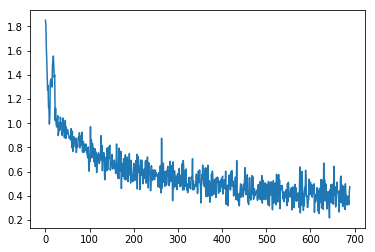

In [6]:
# plot loss, total classifications, mean over splits, and std over splits
model.plot()
print(sum(conf_mat))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

#create accuracy (sum of diagonal dividied by total classified)
mat = sum(conf_mat)
diag = sum(np.diagonal(mat))
print(diag/sum(sum(mat))*100)

#find and print standard deviations
stds = np.std(conf_mat,axis=0)
var = 0
for i in range(conf_mat.shape[1]):
    var += stds[i,i]**2
print(np.sqrt(var)/sum(sum(mat))*100)
print(np.sqrt(var))

In [7]:
#give a prediction example
labels = np.array(['High','Med','Low'])
test = np.reshape(x_test[0],(1,len(x_test[0])))
prediction = model.predict(test)
print("Predicted label is ", labels[prediction[0][0]])
tested_y = np.ndarray.astype(y_test[0],bool)
print("Actual label is ",labels[tested_y][0])

INFO:tensorflow:Restoring parameters from model/basic_model
Predicted label is  High
Actual label is  High


In [8]:
# find and print mean and totals in LaTeX code
mean = np.mean(conf_mat,axis=0)
totals_b = np.sum(mean,axis=0)
totals_r = np.sum(mean,axis=1)
total = np.sum(totals_r)
print(end='\\rota{Actual}')
for i in range(mean.shape[0]):
    print(" & {0:s} & {1:.1f} & {2:.1f} & {3:.1f} & {4:.1f} \\\\".format(labels[i],mean[i,0],mean[i,1],mean[i,2],totals_r[i]))
print('\\toprule')
print(" & Totals & {0:.1f} & {1:.1f} & {2:.1f} & {3:.1f}".format(totals_b[0],totals_b[1],totals_b[2],total))

\rota{Actual} & High & 76.6 & 3.9 & 2.0 & 82.5 \\
 & Med & 7.9 & 18.0 & 9.1 & 35.0 \\
 & Low & 2.6 & 2.3 & 44.6 & 49.5 \\
\toprule
 & Totals & 87.1 & 24.2 & 55.7 & 167.0


In [9]:
#create new confusion matrix
conf_mat = np.empty((x.shape[1],splits,num_labels,num_labels))

#remove each joint from input and retrain with k-folds
for i in range(x.shape[1]):
    print(i)
    sub_x = np.delete(x,i,1)
    sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
    j = 0
    for train_index, test_index in kf.split(sub_x):
        x_train, x_test = sub_x[train_index], sub_x[test_index]
        y_train, y_test = oh_y[train_index], oh_y[test_index]
        model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
        model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
        conf_mat[i,j] = confusion_matrix(y[test_index],model.predict(x_test)[0])
        j += 1

0
number of batches for training: 23
0.018869400024414062
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 14.97005988023952%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.101796407185624%
epoch 4
Best validation accuracy! iteration:75 accuracy: 56.287425149700596%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.66467065868264%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.8562874251497%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.65269461077844%
epoch 8
Best validation accuracy! iteration:175 accuracy: 75.44910179640718%
epoch 9
Best validation accuracy! iteration:200 accuracy: 76.04790419161677%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.64670658682635%
epoch 11
Best validation accuracy! iteration:250 accuracy: 78.44311377245509%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.04191616766467%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 

number of batches for training: 23
0.01670551300048828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.91616766467065%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.09580838323353%
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.8562874251497%
epoch 5
Best validation accuracy! iteration:100 accuracy: 75.44910179640718%
epoch 6
Best validation accuracy! iteration:125 accuracy: 77.24550898203593%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 78.44311377245509%
epoch 9
Best validation accuracy! iteration:200 accuracy: 80.23952095808383%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 82.03592814371258%
epoch 16
Best validation accuracy! iteration:350 accuracy: 83.8323353293413%
epoch 17
Best validation accuracy! iteration:375 accuracy: 85.02994011976048%
epoch 18
Best validation accuracy! iteration:400 accuracy: 85.62874251497006%
epoch 19
Best validation accuracy! ite

epoch 11
Best validation accuracy! iteration:250 accuracy: 73.05389221556887%
epoch 12
Best validation accuracy! iteration:275 accuracy: 73.65269461077844%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 74.25149700598801%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 74.8502994011976%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 75.44910179640718%
epoch 19
Best validation accuracy! iteration:425 accuracy: 76.64670658682635%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 77.84431137724552%
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 78.44311377245509%
epoch 24
Best validation accuracy! iteration:550 accuracy: 79.64071856287424%
epoch 25
Best validation accuracy! iteration:575 accuracy: 80.83832335329342%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 81.437125748503%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 82.03592814371

number of batches for training: 23
0.01950550079345703
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.736526946107784%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.101796407185624%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.26946107784431%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.8622754491018%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.05389221556887%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.25149700598801%
epoch 8
Best validation accuracy! iteration:175 accuracy: 75.44910179640718%
epoch 9
Best validation accuracy! iteration:200 accuracy: 76.04790419161677%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 76.64670658682635%
epoch 18
Best validation accuracy! iteration:400 accuracy: 77.84431137724552%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 78.44311377245509%
epoch 22

number of batches for training: 23
0.016726970672607422
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.50898203592814%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.30538922155689%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.293413173652695%
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.25748502994011%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.05389221556887%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.65269461077844%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.8502994011976%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.24550898203593%
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.84431137724552%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 78.44311377245509%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 79.04191616766467%
epoch 17
epoch 18
Best validation accuracy! iteration

Best validation accuracy! iteration:650 accuracy: 79.04191616766467%
epoch 30
Traning ends. The best valid accuracy is 79.04191616766467. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
3
number of batches for training: 23
0.01659536361694336
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.293413173652695%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 60.47904191616767%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.26946107784431%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.8562874251497%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.25149700598801%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.8502994011976%
epoch 9
Best validation accuracy! iteration:200 accuracy: 78.44311377245509%
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.04191616766467%
epoch 11
Best validation accuracy! iteration:250 accuracy: 80.23952095808383%
epoch 12
Bes

Best validation accuracy! iteration:175 accuracy: 67.66467065868264%
epoch 9
Best validation accuracy! iteration:200 accuracy: 68.26347305389223%
epoch 10
Best validation accuracy! iteration:225 accuracy: 71.8562874251497%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 74.8502994011976%
epoch 15
Best validation accuracy! iteration:325 accuracy: 76.04790419161677%
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.64670658682635%
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 77.24550898203593%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.24550898203593. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.022910356521606445
epoch 1
epoch 2
Best validation accuracy! iteration:

epoch 9
Best validation accuracy! iteration:200 accuracy: 77.24550898203593%
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
Best validation accuracy! iteration:250 accuracy: 79.64071856287424%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 80.23952095808383%
epoch 15
Best validation accuracy! iteration:325 accuracy: 80.83832335329342%
epoch 16
Best validation accuracy! iteration:350 accuracy: 81.437125748503%
epoch 17
Best validation accuracy! iteration:375 accuracy: 82.63473053892216%
epoch 18
Best validation accuracy! iteration:400 accuracy: 85.02994011976048%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.02994011976048. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.01676797866821289
epoch 1
epoch 2
Best validation accuracy! iteration:2

number of batches for training: 23
0.016637086868286133
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.898203592814376%
epoch 3
Best validation accuracy! iteration:50 accuracy: 70.65868263473054%
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.25748502994011%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.05389221556887%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 76.04790419161677%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.84431137724552%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 79.04191616766467%
epoch 12
Best validation accuracy! iteration:275 accuracy: 82.03592814371258%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 82.63473053892216%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 83.8323353293413%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 84.4311377245509%
epoch 21
epoch 22


epoch 11
Best validation accuracy! iteration:250 accuracy: 73.05389221556887%
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.8502994011976%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 80.23952095808383%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 82.03592814371258%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 82.63473053892216%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 83.8323353293413%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.8323353293413. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.016818761825561523
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 72.45508982035929%
epoch 3
Best validation accuracy! iteration:50 accuracy

epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.24550898203593%
epoch 12
Best validation accuracy! iteration:275 accuracy: 80.23952095808383%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 80.83832335329342%
epoch 18
Best validation accuracy! iteration:400 accuracy: 81.437125748503%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 82.63473053892216%
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 83.23353293413174%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.23353293413174. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.01956629753112793
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.50299401197605%
epoch 3
Best validation accuracy! iter

number of batches for training: 23
0.022535324096679688
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 54.49101796407185%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.25748502994011%
epoch 5
Best validation accuracy! iteration:100 accuracy: 76.04790419161677%
epoch 6
Best validation accuracy! iteration:125 accuracy: 76.64670658682635%
epoch 7
Best validation accuracy! iteration:150 accuracy: 77.24550898203593%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 82.03592814371258%
epoch 10
Best validation accuracy! iteration:225 accuracy: 83.8323353293413%
epoch 11
Best validation accuracy! iteration:250 accuracy: 84.4311377245509%
epoch 12
Best validation accuracy! iteration:275 accuracy: 86.22754491017965%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 86.82634730538922%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 88.62275449101796%
epoch 22


Best validation accuracy! iteration:325 accuracy: 77.84431137724552%
epoch 16
Best validation accuracy! iteration:350 accuracy: 78.44311377245509%
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.64071856287424%
epoch 18
Best validation accuracy! iteration:400 accuracy: 80.83832335329342%
epoch 19
Best validation accuracy! iteration:425 accuracy: 81.437125748503%
epoch 20
Best validation accuracy! iteration:450 accuracy: 83.23353293413174%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 83.8323353293413%
epoch 23
Best validation accuracy! iteration:525 accuracy: 85.62874251497006%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 86.22754491017965%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.22754491017965. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.016840219497680664
epoch 1
epoch 2
Best validation accuracy! iter

epoch 10
Best validation accuracy! iteration:225 accuracy: 73.05389221556887%
epoch 11
Best validation accuracy! iteration:250 accuracy: 75.44910179640718%
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.04790419161677%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 76.64670658682635%
epoch 16
Best validation accuracy! iteration:350 accuracy: 77.24550898203593%
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 78.44311377245509%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 79.64071856287424%
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 80.23952095808383%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 80.83832335329342%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.83832335329342. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.01685976

epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 82.03592814371258%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.017262697219848633
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.10778443113773%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.688622754491014%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.26347305389223%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.25149700598801%
epoch 6
Best validation accuracy! iteration:125 accuracy: 75.44910179640718%
epoch 7
Best validation accuracy! iteration:150 accuracy: 76.04790419161677%
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.24550898203593%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.04191616766467%
epoch 11
epoch 12
Best validation ac

number of batches for training: 23
0.02279949188232422
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.50898203592814%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.29940119760479%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.48502994011976%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.65269461077844%
epoch 7
Best validation accuracy! iteration:150 accuracy: 75.44910179640718%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.24550898203593%
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.64071856287424%
epoch 11
Best validation accuracy! iteration:250 accuracy: 82.03592814371258%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 83.23353293413174%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 84.4311377245509%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 

epoch 24
Best validation accuracy! iteration:550 accuracy: 90.41916167664671%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 90.41916167664671. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.017191171646118164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 23.353293413173652%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.91017964071856%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.26347305389223%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.05988023952095%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.65269461077844%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 78.44311377245509%
epoch 9
Best validation accuracy! iteration:200 accuracy: 79.04191616766467%
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.64071856287424%
epoch 11
epoch 12
epoch 13
epoch 14


epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 82.03592814371258%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 83.8323353293413%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 84.4311377245509%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.4311377245509. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.016819000244140625
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.101796407185624%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.898203592814376%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.08383233532935%
epoch 5
Best validation accuracy! iteration:100 accuracy: 60.47904191616767%
epoch 6
Best validation accuracy! iteration:125 accuracy: 61.07784431137725%
epoch 7
Best validation accuracy! iteration:150 accuracy: 63.47305389221557%
epoch 8
Best validation accuracy! iteration:1

epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.83832335329342. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.020756244659423828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.712574850299404%
epoch 3
Best validation accuracy! iteration:50 accuracy: 67.06586826347305%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.26347305389223%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 68.8622754491018%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 70.05988023952095%
epoch 9
Best validation accuracy! iteration:200 accuracy: 72.45508982035929%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.05389221556887%
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.64670658682635%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.84431137724552%
e

Best validation accuracy! iteration:200 accuracy: 68.26347305389223%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.65269461077844%
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.04790419161677%
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.24550898203593%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.04191616766467%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 80.83832335329342%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 82.03592814371258%
epoch 19
Best validation accuracy! iteration:425 accuracy: 83.23353293413174%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 84.4311377245509%
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 85.02994011976048%
epoch 24
Best validation accuracy! iteration:550 accuracy: 86.22754491017965%
epoch 25
Best validation accuracy! iteration:575 accuracy: 86.82634730538922%
epoch 26
epoch 27
epoch 28
ep

Best validation accuracy! iteration:200 accuracy: 72.45508982035929%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.65269461077844%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 74.8502994011976%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 75.44910179640718%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 76.04790419161677%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 77.84431137724552%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.84431137724552. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.01765894889831543
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.30538922155689%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 52.69461077844312%
epoch 5
Best validation accura

epoch 10
Best validation accuracy! iteration:225 accuracy: 69.46107784431138%
epoch 11
Best validation accuracy! iteration:250 accuracy: 70.05988023952095%
epoch 12
Best validation accuracy! iteration:275 accuracy: 71.8562874251497%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 72.45508982035929%
epoch 15
Best validation accuracy! iteration:325 accuracy: 73.65269461077844%
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.04790419161677%
epoch 17
Best validation accuracy! iteration:375 accuracy: 77.84431137724552%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 79.04191616766467%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 79.64071856287424%
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 80.23952095808383%
Traning ends. The best valid accuracy is 80.23952095808383. Model named basic_model.
INFO:tensorflow:Restoring parameters 

In [10]:
# print sums, means, and stds
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    print(sum(conf_mat[i]))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

R Shoulder
[[765.  49.  11.]
 [ 73. 188.  89.]
 [ 30.  20. 445.]]
R Elbow
[[766.  48.  11.]
 [ 91. 164.  95.]
 [ 26.  16. 453.]]
R Wrist
[[769.  41.  15.]
 [ 76. 194.  80.]
 [ 28.  23. 444.]]
R Hip
[[758.  50.  17.]
 [ 89. 176.  85.]
 [ 27.  23. 445.]]
L Shoulder
[[757.  56.  12.]
 [ 80. 183.  87.]
 [ 32.  22. 441.]]
L Elbow
[[771.  44.  10.]
 [ 85. 179.  86.]
 [ 33.  16. 446.]]
L Hand
[[758.  53.  14.]
 [ 65. 201.  84.]
 [ 30.  29. 436.]]
L Hip
[[753.  52.  20.]
 [ 81. 183.  86.]
 [ 29.  21. 445.]]
Chest
[[755.  55.  15.]
 [ 90. 161.  99.]
 [ 25.  18. 452.]]
Pelvis
[[776.  39.  10.]
 [ 87. 171.  92.]
 [ 33.  13. 449.]]
Neck
[[768.  45.  12.]
 [ 78. 183.  89.]
 [ 27.  26. 442.]]
Pate
[[761.  55.   9.]
 [ 69. 190.  91.]
 [ 26.  24. 445.]]
Gun
[[754.  42.  29.]
 [ 68. 152. 130.]
 [ 50.  29. 416.]]
mean
[[[82.15384615  3.30769231  1.53846154]
  [ 8.76923077 12.15384615  7.07692308]
  [ 6.15384615  2.84615385 43.        ]]

 [[77.53846154  4.46153846  2.        ]
  [ 6.30769231 14.76923077

In [11]:
# set variables for mean, variance, and sum values
m = 0
v = 0
s = 0

#for each joint, calculate accuracy %, mean, and std
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    mat = sum(conf_mat[i])
    diag = sum(np.diagonal(mat))
    print(diag/sum(sum(mat))*100)
    m += diag/sum(sum(mat))*100
    stds = np.std(conf_mat[i],axis=0)
    var = 0
    for j in range(stds.shape[1]):
        var += stds[j,j]**2
    v += var
    s += sum(sum(mat))
    
print(1)
print(m/(conf_mat.shape[0]-1))
print(np.sqrt(v)/s*100)

R Shoulder
83.7125748502994
R Elbow
82.81437125748504
R Wrist
84.25149700598801
R Hip
82.57485029940119
L Shoulder
82.6946107784431
L Elbow
83.59281437125749
L Hand
83.53293413173652
L Hip
82.6946107784431
Chest
81.91616766467065
Pelvis
83.59281437125749
Neck
83.41317365269461
Pate
83.59281437125749
Gun
79.1616766467066
1
89.79540918163673
0.1768368265797285


In [12]:
# create empty confusion matrix
conf_mat = np.empty((x.shape[1],x.shape[1],splits,num_labels,num_labels))

#remove two joints and retrain network with k-folds
for i in range(x.shape[1]):
    for j in range(i,x.shape[1]):
        sub_x = np.delete(x,[i,j],1)
        sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
        k = 0
        for train_index, test_index in kf.split(sub_x):
            x_train, x_test = sub_x[train_index], sub_x[test_index]
            y_train, y_test = oh_y[train_index], oh_y[test_index]
            model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
            model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64,model_name="model")
            conf_mat[i,j,k] = confusion_matrix(y[test_index],model.predict(x_test)[0])
            k+= 1

number of batches for training: 23
0.019250869750976562
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.09580838323353%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.48502994011976%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.26946107784431%
epoch 6
Best validation accuracy! iteration:125 accuracy: 76.64670658682635%
epoch 7
Best validation accuracy! iteration:150 accuracy: 79.04191616766467%
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.04191616766467. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01690840721130371
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.706586826347305%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.4970059

epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 89.82035928143712%
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 90.41916167664671%
epoch 30
Traning ends. The best valid accuracy is 90.41916167664671. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016678333282470703
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.712574850299404%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.08383233532935%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.86826347305389%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.65868263473054%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 72.45508982035929%
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.84431137724552%
epoch 9
Best validation accuracy! iteration:200 accuracy: 80.23952095808383%
epoch 10
Best validation accuracy! iteration:225

epoch 22
Best validation accuracy! iteration:500 accuracy: 78.44311377245509%
epoch 23
Best validation accuracy! iteration:525 accuracy: 79.04191616766467%
epoch 24
Best validation accuracy! iteration:550 accuracy: 80.23952095808383%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 80.83832335329342%
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 81.437125748503%
epoch 30
Best validation accuracy! iteration:675 accuracy: 82.63473053892216%
Traning ends. The best valid accuracy is 82.63473053892216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016837120056152344
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 26.34730538922156%
epoch 3
Best validation accuracy! iteration:50 accuracy: 34.73053892215569%
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.700598802395206%
epoch 5
Best validation accuracy! iteration:100 accuracy: 55.688622754491014%
epo

epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.65269461077844%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.25149700598801%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 76.64670658682635%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 77.24550898203593%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.24550898203593. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016712188720703125
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.700598802395206%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.49101796407185%
epoch 4
Best validation accuracy! iteration:75 accuracy: 60.47904191616767%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.46706586826348%
epoch 6
Best validation 

epoch 21
Best validation accuracy! iteration:475 accuracy: 86.22754491017965%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 86.82634730538922%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.82634730538922. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016666650772094727
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.287425149700596%
epoch 3
Best validation accuracy! iteration:50 accuracy: 73.05389221556887%
epoch 4
Best validation accuracy! iteration:75 accuracy: 78.44311377245509%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 79.04191616766467%
epoch 9
Best validation accuracy! iteration:200 accuracy: 80.23952095808383%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 82.03592814371258%
epoch 16
epoch 17
epoch 18
epoch 19
Best vali

number of batches for training: 23
0.017020702362060547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 26.34730538922156%
epoch 3
Best validation accuracy! iteration:50 accuracy: 39.52095808383233%
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.25748502994011%
epoch 5
Best validation accuracy! iteration:100 accuracy: 75.44910179640718%
epoch 6
Best validation accuracy! iteration:125 accuracy: 76.64670658682635%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.84431137724552%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 78.44311377245509%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 79.04191616766467%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 79.64071856287424%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 80.83832335329342%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 a

epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 88.02395209580838. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.023003578186035156
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.34131736526946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 35.32934131736527%
epoch 4
Best validation accuracy! iteration:75 accuracy: 44.91017964071856%
epoch 5
Best validation accuracy! iteration:100 accuracy: 54.49101796407185%
epoch 6
Best validation accuracy! iteration:125 accuracy: 64.67065868263472%
epoch 7
Best validation accuracy! iteration:150 accuracy: 70.05988023952095%
epoch 8
Best validation accuracy! iteration:175 accuracy: 72.45508982035929%
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch 11
epoch 12
Best validation accuracy! iteration:275 

epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 83.8323353293413%
epoch 30
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01743793487548828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.11377245508982%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.700598802395206%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 51.49700598802395%
epoch 6
Best validation accuracy! iteration:125 accuracy: 61.67664670658682%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.05389221556887%
epoch 8
Best validation accuracy! iteration:175 accuracy: 78.44311377245509%
epoch 9
Best validation accuracy! iteration:200 accuracy: 80.23952095808383%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 80.83832335329342%
epoch 12
Best validation accurac

epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.24550898203593. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.02267313003540039
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 67.66467065868264%
epoch 3
Best validation accuracy! iteration:50 accuracy: 71.8562874251497%
epoch 4
Best validation accuracy! iteration:75 accuracy: 74.25149700598801%
epoch 5
Best validation accuracy! iteration:100 accuracy: 75.44910179640718%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 76.04790419161677%
epoch 8
Best validation accuracy! iteration:175 accuracy: 76.64670658682635%
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.84431137724552%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 78.44311377245509%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 79.04191616766467%
epoch 17
epoch 

epoch 23
Best validation accuracy! iteration:525 accuracy: 84.4311377245509%
epoch 24
Best validation accuracy! iteration:550 accuracy: 86.22754491017965%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.22754491017965. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016763925552368164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.50299401197605%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.69461077844312%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.293413173652695%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.47305389221557%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.8502994011976%
epoch 8
Best validation accuracy! iteration:175 accuracy: 78.44311377245509%
epoch 9
Best validation accuracy! iteration:200 accuracy: 

epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.64670658682635%
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.84431137724552%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 80.83832335329342%
epoch 15
Best validation accuracy! iteration:325 accuracy: 81.437125748503%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 82.03592814371258%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 82.63473053892216%
epoch 23
Best validation accuracy! iteration:525 accuracy: 83.23353293413174%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 85.62874251497006%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.62874251497006. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01673436164855957
epoch

epoch 25
Best validation accuracy! iteration:575 accuracy: 85.62874251497006%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.62874251497006. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016779184341430664
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.11377245508982%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 46.706586826347305%
epoch 5
Best validation accuracy! iteration:100 accuracy: 53.89221556886228%
epoch 6
Best validation accuracy! iteration:125 accuracy: 62.27544910179641%
epoch 7
Best validation accuracy! iteration:150 accuracy: 70.05988023952095%
epoch 8
Best validation accuracy! iteration:175 accuracy: 71.25748502994011%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 72.45508982035929%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
Best validation accuracy! iteration:27

epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.63473053892216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.02042245864868164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.11377245508982%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.91017964071856%
epoch 4
Best validation accuracy! iteration:75 accuracy: 47.30538922155689%
epoch 5
Best validation accuracy! iteration:100 accuracy: 52.69461077844312%
epoch 6
Best validation accuracy! iteration:125 accuracy: 65.26946107784431%
epoch 7
Best validation accuracy! iteration:150 accuracy: 70.65868263473054%
epoch 8
Best validation accuracy! iteration:175 accuracy: 73.05389221556887%
epoch 9
Best validation accuracy! iteration:200 accuracy: 75.44910179640718%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.646706

epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.04191616766467. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.021087646484375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.898203592814376%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.49700598802395%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.293413173652695%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 53.89221556886228%
epoch 7
Best validation accuracy! iteration:150 accuracy: 61.67664670658682%
epoch 8
Best validation accuracy! iteration:175 accuracy: 66.46706586826348%
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.24550898203593%
epoch 13
epoch

number of batches for training: 23
0.017026185989379883
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.51497005988024%
epoch 3
Best validation accuracy! iteration:50 accuracy: 63.47305389221557%
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.25748502994011%
epoch 5
Best validation accuracy! iteration:100 accuracy: 72.45508982035929%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.05389221556887%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.8502994011976%
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.84431137724552%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.04191616766467%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.64071856287424%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 82.03592814371258%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 83.23353293413174%
epoch 21
epoch 22


epoch 12
Best validation accuracy! iteration:275 accuracy: 70.65868263473054%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 73.05389221556887%
epoch 15
Best validation accuracy! iteration:325 accuracy: 75.44910179640718%
epoch 16
Best validation accuracy! iteration:350 accuracy: 77.84431137724552%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 78.44311377245509%
epoch 23
Best validation accuracy! iteration:525 accuracy: 79.04191616766467%
epoch 24
Best validation accuracy! iteration:550 accuracy: 80.83832335329342%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 81.437125748503%
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.03592814371258%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01678180694580078
epoch 1
epoch 2
Best v

epoch 9
Best validation accuracy! iteration:200 accuracy: 79.04191616766467%
epoch 10
Best validation accuracy! iteration:225 accuracy: 81.437125748503%
epoch 11
Best validation accuracy! iteration:250 accuracy: 82.03592814371258%
epoch 12
Best validation accuracy! iteration:275 accuracy: 83.23353293413174%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 83.8323353293413%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 86.22754491017965%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.22754491017965. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01708531379699707
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.11377245508982%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.30538922155689%
epoch 4
Best validation accuracy! iteration:

epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.64071856287424. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.022584199905395508
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.91017964071856%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.90419161676647%
epoch 4
Best validation accuracy! iteration:75 accuracy: 72.45508982035929%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.05389221556887%
epoch 6
Best validation accuracy! iteration:125 accuracy: 74.8502994011976%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 76.04790419161677%
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.84431137724552%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 79.64071856287424%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 80.23952095808383%
epoch

epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.24550898203593. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016523122787475586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.898203592814376%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.88023952095808%
epoch 4
Best validation accuracy! iteration:75 accuracy: 73.65269461077844%
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.8502994011976%
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.64670658682635%
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.24550898203593%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 77.84431137724552%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! it

number of batches for training: 23
0.016771793365478516
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 57.48502994011976%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.07784431137725%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.07185628742515%
epoch 6
Best validation accuracy! iteration:125 accuracy: 65.26946107784431%
epoch 7
Best validation accuracy! iteration:150 accuracy: 77.84431137724552%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 80.23952095808383%
epoch 10
Best validation accuracy! iteration:225 accuracy: 82.03592814371258%
epoch 11
Best validation accuracy! iteration:250 accuracy: 83.8323353293413%
epoch 12
Best validation accuracy! iteration:275 accuracy: 85.02994011976048%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 86.22754491017965%
epoch 16
Best validation accuracy! iteration:350 accuracy: 86.82634730538922%
epoch 17
epoch 18
Best validation accuracy! iteration

Best validation accuracy! iteration:225 accuracy: 64.67065868263472%
epoch 11
Best validation accuracy! iteration:250 accuracy: 67.66467065868264%
epoch 12
Best validation accuracy! iteration:275 accuracy: 68.8622754491018%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 70.05988023952095%
epoch 15
Best validation accuracy! iteration:325 accuracy: 71.25748502994011%
epoch 16
Best validation accuracy! iteration:350 accuracy: 71.8562874251497%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 72.45508982035929%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 73.65269461077844%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 74.25149700598801%
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 75.44910179640718%
epoch 30
Traning ends. The best valid accuracy is 75.44910179640718. Model named model.
INFO:tensorflow:Restoring parameters from model/model

epoch 10
Best validation accuracy! iteration:225 accuracy: 71.25748502994011%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 71.8562874251497%
epoch 21
Best validation accuracy! iteration:475 accuracy: 74.25149700598801%
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 74.8502994011976%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 76.64670658682635%
epoch 30
Traning ends. The best valid accuracy is 76.64670658682635. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01922321319580078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.31137724550898%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 45.50898203592814%
epoch 6
Best validation accuracy! iteration:125 accuracy: 50.29940119760479%
epoch 7
Best validation ac

epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.8502994011976%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.64670658682635%
epoch 17
Best validation accuracy! iteration:375 accuracy: 77.24550898203593%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 77.84431137724552%
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 78.44311377245509%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.44311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01708078384399414
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 19.16167664670659%
epoch 3
Best validation accuracy! iteration:50 accuracy: 35.92814371257485%
epoch 4
Best validation accuracy! iteration:75 accuracy: 46

epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.8502994011976%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 75.44910179640718%
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.04790419161677%
epoch 17
Best validation accuracy! iteration:375 accuracy: 76.64670658682635%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 77.84431137724552%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 80.23952095808383%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 80.83832335329342%
epoch 30
Traning ends. The best valid accuracy is 80.83832335329342. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016628503799438477
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.52694610778443%
epoch 3
Best validation accuracy! iteration:50 a

epoch 9
Best validation accuracy! iteration:200 accuracy: 80.23952095808383%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 80.83832335329342%
epoch 16
Best validation accuracy! iteration:350 accuracy: 82.03592814371258%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 82.63473053892216%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.63473053892216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016773223876953125
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.12574850299401%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.706586826347305%
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.700598802395206%
epoch 5
Best validation accuracy! iteration:100 accuracy: 58.68263473053892%
epoch 6
Best validation

epoch 11
Best validation accuracy! iteration:250 accuracy: 78.44311377245509%
epoch 12
Best validation accuracy! iteration:275 accuracy: 79.64071856287424%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 80.83832335329342%
epoch 16
Best validation accuracy! iteration:350 accuracy: 81.437125748503%
epoch 17
Best validation accuracy! iteration:375 accuracy: 82.03592814371258%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 82.63473053892216%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 83.23353293413174%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.23353293413174. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01692676544189453
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.29940119760479%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 53

epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.04790419161677%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.24550898203593%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 77.84431137724552%
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 79.64071856287424%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 80.83832335329342%
Traning ends. The best valid accuracy is 80.83832335329342. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017266511917114258
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.13173652694611%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.67664670658682%
epoch 4
Best validation accuracy! iteration:75 ac

epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.03592814371258%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016695022583007812
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 33.532934131736525%
epoch 3
Best validation accuracy! iteration:50 accuracy: 39.52095808383233%
epoch 4
Best validation accuracy! iteration:75 accuracy: 44.91017964071856%
epoch 5
Best validation accuracy! iteration:100 accuracy: 46.10778443113773%
epoch 6
Best validation accuracy! iteration:125 accuracy: 47.90419161676647%
epoch 7
Best validation accuracy! iteration:150 accuracy: 48.50299401197605%
epoch 8
Best validation accuracy! iteration:175 accuracy: 52.09580838323353%
epoch 9
Best validation accuracy! iteration:200 accuracy: 60.47904191616767%
epoch 10
Best validation accuracy! iteration:225 accuracy: 65.8682634730538

epoch 9
Best validation accuracy! iteration:200 accuracy: 75.44910179640718%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.04790419161677%
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.64670658682635%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.84431137724552%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.04191616766467%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 79.64071856287424%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.64071856287424. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01675868034362793
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.700598802395206%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.07185628742515%
epoch 4
Best validation accuracy! iterat

epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.84431137724552%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 78.44311377245509%
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 80.83832335329342%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 81.437125748503%
epoch 21
Best validation accuracy! iteration:475 accuracy: 82.03592814371258%
epoch 22
Best validation accuracy! iteration:500 accuracy: 83.8323353293413%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 85.02994011976048%
Traning ends. The best valid accuracy is 85.02994011976048. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016918659210205078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 

epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.64670658682635%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 78.44311377245509%
epoch 22
Best validation accuracy! iteration:500 accuracy: 79.04191616766467%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 80.23952095808383%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.23952095808383. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017021894454956055
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.29940119760479%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.68263473053892%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.47305389221557%
epoch 6
Best validation accuracy

epoch 9
Best validation accuracy! iteration:200 accuracy: 69.46107784431138%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 70.65868263473054%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 71.25748502994011%
epoch 16
Best validation accuracy! iteration:350 accuracy: 71.8562874251497%
epoch 17
Best validation accuracy! iteration:375 accuracy: 74.25149700598801%
epoch 18
Best validation accuracy! iteration:400 accuracy: 75.44910179640718%
epoch 19
Best validation accuracy! iteration:425 accuracy: 76.64670658682635%
epoch 20
Best validation accuracy! iteration:450 accuracy: 77.84431137724552%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 78.44311377245509%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.44311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.0168020725250

epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 78.44311377245509%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 79.04191616766467%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.04191616766467. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016825437545776367
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.90419161676647%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.08982035928144%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.86826347305389%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.06586826347305%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best vali

Best validation accuracy! iteration:225 accuracy: 78.44311377245509%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.04191616766467%
epoch 18
Best validation accuracy! iteration:400 accuracy: 80.83832335329342%
epoch 19
Best validation accuracy! iteration:425 accuracy: 81.437125748503%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 82.03592814371258%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016698360443115234
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.101796407185624%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.27544910179641%
epoch 4
Best validation accuracy! iteration:75 accuracy: 66.46706586826348%
epoch 5
Best validation accuracy! iteration:100 acc

Best validation accuracy! iteration:450 accuracy: 82.63473053892216%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 83.8323353293413%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016803741455078125
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.34131736526946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.07784431137725%
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.25748502994011%
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.8562874251497%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 72.45508982035929%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.8502994011976%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 75.44910179640718%
epoch 11
Best validation a

Best validation accuracy! iteration:200 accuracy: 70.05988023952095%
epoch 10
Best validation accuracy! iteration:225 accuracy: 71.8562874251497%
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.05389221556887%
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.25149700598801%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 74.8502994011976%
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.04790419161677%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 77.84431137724552%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 78.44311377245509%
epoch 21
Best validation accuracy! iteration:475 accuracy: 79.04191616766467%
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 79.64071856287424%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.64071856287424. Model named model.
INFO:tensorflow:Restoring parameters from mo

epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 79.64071856287424%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.64071856287424. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016934633255004883
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.700598802395206%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.09580838323353%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.293413173652695%
epoch 5
Best validation accuracy! iteration:100 accuracy: 53.89221556886228%
epoch 6
Best validation accuracy! iteration:125 accuracy: 64.67065868263472%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.05389221556887%
epoch 8
Best validation accuracy! iteration:175 accuracy: 75.44910179640718%
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 78.44311377245509%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Be

number of batches for training: 23
0.0168912410736084
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.89221556886228%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.08982035928144%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.26946107784431%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.65269461077844%
epoch 6
Best validation accuracy! iteration:125 accuracy: 74.8502994011976%
epoch 7
Best validation accuracy! iteration:150 accuracy: 76.64670658682635%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 78.44311377245509%
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.64071856287424%
epoch 11
Best validation accuracy! iteration:250 accuracy: 80.23952095808383%
epoch 12
Best validation accuracy! iteration:275 accuracy: 81.437125748503%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 82.63473053892216%
epoch 18
epoch 19
epoch 20
Best validation accura

epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 79.04191616766467%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.04191616766467. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017025470733642578
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.29940119760479%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 52.09580838323353%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.48502994011976%
epoch 6
Best validation accuracy! iteration:125 accuracy: 63.47305389221557%
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 64.07185628742515%
epoch 10
Best validation accuracy! iteration:225 accuracy: 66.46706586826348%
epoch 11
Best validation accuracy! iteration:250 accuracy: 68.8622754491018%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 70.05988023952095%
epoc

epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.65269461077844%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 74.8502994011976%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 75.44910179640718%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.44910179640718. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01730823516845703
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.712574850299404%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.91017964071856%
epoch 4
Best validation accuracy! iteration:75 accuracy: 50.29940119760479%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.47305389221557%
epoch 6
Best validation ac

number of batches for training: 23
0.01755833625793457
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.712574850299404%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.67065868263472%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.8622754491018%
epoch 5
Best validation accuracy! iteration:100 accuracy: 69.46107784431138%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.25748502994011%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.25149700598801%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.8502994011976%
epoch 12
Best validation accuracy! iteration:275 accuracy: 75.44910179640718%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.04790419161677%
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.84431137724

Best validation accuracy! iteration:200 accuracy: 70.05988023952095%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 71.25748502994011%
epoch 15
Best validation accuracy! iteration:325 accuracy: 73.65269461077844%
epoch 16
Best validation accuracy! iteration:350 accuracy: 74.25149700598801%
epoch 17
Best validation accuracy! iteration:375 accuracy: 75.44910179640718%
epoch 18
Best validation accuracy! iteration:400 accuracy: 76.64670658682635%
epoch 19
Best validation accuracy! iteration:425 accuracy: 77.24550898203593%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 77.84431137724552%
epoch 22
Best validation accuracy! iteration:500 accuracy: 80.23952095808383%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 80.83832335329342%
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 82.63473053892216%
epoch 30
Traning ends. The best valid accuracy is 82.63473053

Best validation accuracy! iteration:525 accuracy: 84.4311377245509%
epoch 24
Best validation accuracy! iteration:550 accuracy: 85.02994011976048%
epoch 25
Best validation accuracy! iteration:575 accuracy: 88.02395209580838%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 88.02395209580838. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017673969268798828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.51497005988024%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.47904191616767%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.86826347305389%
epoch 6
Best validation accuracy! iteration:125 accuracy: 68.8622754491018%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 70.65868263473054%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 72.45508982035929%
epoch 11
Best validation accuracy! iteration:250 a

epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 85.02994011976048%
Traning ends. The best valid accuracy is 85.02994011976048. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.0178525447845459
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.32335329341318%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.30538922155689%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.88023952095808%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.8622754491018%
epoch 6
Best validation accuracy! iteration:125 accuracy: 72.45508982035929%
epoch 7
Best validation accuracy! iteration:150 accuracy: 75.44910179640718%
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.24550898203593%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.64071856287424%
epoch 11
Best validation accuracy!

Best validation accuracy! iteration:225 accuracy: 73.65269461077844%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 74.8502994011976%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 75.44910179640718%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.44910179640718. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01812291145324707
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.119760479041915%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.91017964071856%
epoch 4
Best validation accuracy! iteration:75 accuracy: 45.50898203592814%
epoch 5
Best validation accuracy! iteration:100 accuracy: 49.700598802395206%
epoch 6
Best validation accuracy! iteration:125 accuracy: 51.49700598802395%
epoch 7
Best validation accuracy! 

epoch 22
Best validation accuracy! iteration:500 accuracy: 88.02395209580838%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 88.02395209580838. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.018636703491210938
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.2814371257485%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.07185628742515%
epoch 4
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 65.26946107784431%
epoch 7
Best validation accuracy! iteration:150 accuracy: 70.05988023952095%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.8502994011976%
epoch 9
Best validation accuracy! iteration:200 accuracy: 79.04191616766467%
epoch 10
Best validation accuracy! iteration:225 accuracy: 81.437125748503%
epoch 11
Best validation accuracy! iteration:250 accuracy: 84.4311377245509%
epoch 12
epoch 13
epoch 14

epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 78.44311377245509%
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 79.64071856287424%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 80.23952095808383%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 81.437125748503%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.63473053892216%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.63473053892216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.018988370895385742
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.101796407185624%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.48502994011976%
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.8562874251497%
e

Best validation accuracy! iteration:275 accuracy: 82.63473053892216%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 83.23353293413174%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 83.8323353293413%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 85.62874251497006%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 86.22754491017965%
epoch 30
Traning ends. The best valid accuracy is 86.22754491017965. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.020630359649658203
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.92814371257485%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 36.52694610778443%
epoch 5
Best validation accuracy! iteration:100 accuracy: 38.92215568862276%
epoch 6
Best validation accuracy! iteration:125 accuracy: 43

Best validation accuracy! iteration:525 accuracy: 82.03592814371258%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 82.63473053892216%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 83.8323353293413%
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 84.4311377245509%
epoch 30
Traning ends. The best valid accuracy is 84.4311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.019840478897094727
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 16.16766467065868%
epoch 3
Best validation accuracy! iteration:50 accuracy: 38.32335329341318%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.27544910179641%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.8622754491018%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.25748502994011%
epoch 8
B

epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 72.45508982035929%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 73.05389221556887%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 73.65269461077844%
epoch 18
Best validation accuracy! iteration:400 accuracy: 74.25149700598801%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 74.8502994011976%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 75.44910179640718%
epoch 23
Best validation accuracy! iteration:525 accuracy: 76.04790419161677%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 76.64670658682635%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.64670658682635. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.020000219345092773
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.497005988023

epoch 9
Best validation accuracy! iteration:200 accuracy: 71.8562874251497%
epoch 10
Best validation accuracy! iteration:225 accuracy: 72.45508982035929%
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.05389221556887%
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.25149700598801%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 74.8502994011976%
epoch 15
Best validation accuracy! iteration:325 accuracy: 75.44910179640718%
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.64670658682635%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 77.24550898203593%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 77.84431137724552%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 79.04191616766467%
epoch 23
Best validation accuracy! iteration:525 accuracy: 80.23952095808383%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 80.83832335329342%
epoch 26
epoch 27
epoc

epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.64670658682635%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 77.84431137724552%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 78.44311377245509%
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.04191616766467%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 80.23952095808383%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 81.437125748503%
epoch 30
Traning ends. The best valid accuracy is 81.437125748503. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.020611047744750977
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.11377245508982%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.29940119760479%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.8

epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.65269461077844%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.8502994011976%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.04790419161677%
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.24550898203593%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 78.44311377245509%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 79.04191616766467%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 80.23952095808383%
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 81.437125748503%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 82.03592814371258%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 82.63473053892216%
Traning ends. The best valid accuracy is 82.63473053892216. Model named model.
INFO:tensorflow:Restoring parameters 

epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 67.66467065868264%
epoch 12
Best validation accuracy! iteration:275 accuracy: 72.45508982035929%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 74.8502994011976%
epoch 15
Best validation accuracy! iteration:325 accuracy: 75.44910179640718%
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.04790419161677%
epoch 17
Best validation accuracy! iteration:375 accuracy: 76.64670658682635%
epoch 18
Best validation accuracy! iteration:400 accuracy: 77.24550898203593%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 80.23952095808383%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 80.83832335329342%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.83832335329342. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01662468910217285
epo

epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 78.44311377245509%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.44311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016592741012573242
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.700598802395206%
epoch 3
Best validation accuracy! iteration:50 accuracy: 72.45508982035929%
epoch 4
Best validation accuracy! iteration:75 accuracy: 76.04790419161677%
epoch 5
Best validation accuracy! iteration:100 accuracy: 76.64670658682635%
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
Best validation accuracy! iteration:250 accuracy: 7

epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 75.44910179640718%
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.24550898203593%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
Best validation accuracy! iteration:350 accuracy: 79.64071856287424%
epoch 17
Best validation accuracy! iteration:375 accuracy: 82.03592814371258%
epoch 18
Best validation accuracy! iteration:400 accuracy: 82.63473053892216%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 85.02994011976048%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 85.62874251497006%
epoch 24
Best validation accuracy! iteration:550 accuracy: 86.22754491017965%
epoch 25
Best validation accuracy! iteration:575 accuracy: 86.82634730538922%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 87.42514970059881%
Traning ends. The best valid accuracy is 87.

number of batches for training: 23
0.016888141632080078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.700598802395206%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 50.29940119760479%
epoch 5
Best validation accuracy! iteration:100 accuracy: 55.08982035928144%
epoch 6
Best validation accuracy! iteration:125 accuracy: 62.27544910179641%
epoch 7
Best validation accuracy! iteration:150 accuracy: 77.24550898203593%
epoch 8
Best validation accuracy! iteration:175 accuracy: 79.04191616766467%
epoch 9
Best validation accuracy! iteration:200 accuracy: 79.64071856287424%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 80.23952095808383%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 82.03592814371258%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Mod

epoch 8
Best validation accuracy! iteration:175 accuracy: 74.8502994011976%
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.24550898203593%
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 78.44311377245509%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.64071856287424%
epoch 15
Best validation accuracy! iteration:325 accuracy: 80.23952095808383%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 80.83832335329342%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 81.437125748503%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.437125748503. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.020111083984375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accurac

epoch 25
Best validation accuracy! iteration:575 accuracy: 74.25149700598801%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.25149700598801. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01761603355407715
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.712574850299404%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.898203592814376%
epoch 4
Best validation accuracy! iteration:75 accuracy: 52.69461077844312%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.88023952095808%
epoch 6
Best validation accuracy! iteration:125 accuracy: 68.8622754491018%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.8562874251497%
epoch 8
Best validation accuracy! iteration:175 accuracy: 73.65269461077844%
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
epoch 13
epoch 14
epoch 15
Best validatio

epoch 10
Best validation accuracy! iteration:225 accuracy: 68.26347305389223%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 70.65868263473054%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 73.05389221556887%
epoch 16
Best validation accuracy! iteration:350 accuracy: 74.25149700598801%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 76.04790419161677%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.04790419161677. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.020202159881591797
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.886227544910184%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.48502994011976%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.06586826347305%
epoch 5
Best validation accuracy! iterat

epoch 23
Best validation accuracy! iteration:525 accuracy: 84.4311377245509%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 85.02994011976048%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 85.62874251497006%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.62874251497006. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01674628257751465
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.08982035928144%
epoch 3
Best validation accuracy! iteration:50 accuracy: 71.8562874251497%
epoch 4
Best validation accuracy! iteration:75 accuracy: 72.45508982035929%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.25149700598801%
epoch 6
Best validation accuracy! iteration:125 accuracy: 76.04790419161677%
epoch 7
Best validation accuracy! iteration:150 accuracy: 77.84431137724552%
epoch 8
Best validation accuracy! iteration:175 accuracy: 80.2395209

epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 83.8323353293413%
epoch 28
Best validation accuracy! iteration:625 accuracy: 84.4311377245509%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.4311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016592741012573242
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.706586826347305%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.90419161676647%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.27544910179641%
epoch 5
Best validation accuracy! iteration:100 accuracy: 69.46107784431138%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best validation accuracy! iteration:150 accuracy: 72.45508982035929%
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.05389221556887%
epoch 11
Best validation accuracy! iterati

epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 85.62874251497006%
epoch 30
Traning ends. The best valid accuracy is 85.62874251497006. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.021988868713378906
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.11377245508982%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 43.712574850299404%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.07784431137725%
epoch 6
Best validation accuracy! iteration:125 accuracy: 72.45508982035929%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.25149700598801%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.8502994011976%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 78.44311377245509%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.64071856287424%
epoch 16
epoch 17
epoch 18
epo

epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.84431137724552%
epoch 12
Best validation accuracy! iteration:275 accuracy: 80.23952095808383%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 80.83832335329342%
epoch 15
Best validation accuracy! iteration:325 accuracy: 81.437125748503%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 82.03592814371258%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 83.23353293413174%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 83.8323353293413%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 85.62874251497006%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.62874251497006. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01770472526550293
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 6

epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.023203611373901367
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.74251497005988%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.67065868263472%
epoch 4
Best validation accuracy! iteration:75 accuracy: 73.05389221556887%
epoch 5
Best validation accuracy! iteration:100 accuracy: 76.64670658682635%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.24550898203593%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
Best validation accuracy! iteration:250 accuracy: 80.23952095808383%
epoch 12
Best validation accuracy! iteration:275 accuracy: 81.437125748503%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 83.23353293413174%
epoch 16
Best validation accuracy! iteration:350 ac

epoch 6
Best validation accuracy! iteration:125 accuracy: 73.05389221556887%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.65269461077844%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.25149700598801%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.04790419161677%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.64071856287424%
epoch 16
Best validation accuracy! iteration:350 accuracy: 80.23952095808383%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 81.437125748503%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 82.03592814371258%
epoch 21
Best validation accuracy! iteration:475 accuracy: 83.8323353293413%
epoch 22
Best validation accuracy! iteration:500 accuracy: 84.4311377245509%
epoch 23
Best validation accuracy! iteration:525 accuracy: 86.22754491017965%
epoch 24
epoch 25
B

epoch 22
Best validation accuracy! iteration:500 accuracy: 86.22754491017965%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 86.82634730538922%
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 87.42514970059881%
epoch 30
Best validation accuracy! iteration:675 accuracy: 88.62275449101796%
Traning ends. The best valid accuracy is 88.62275449101796. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.018971681594848633
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.29940119760479%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.49700598802395%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.27544910179641%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.26946107784431%
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 70.05988023952095%
epoch 11
epoch 12
Best validati

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.24550898203593. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.018551111221313477
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.50299401197605%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.07185628742515%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.67065868263472%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.66467065868264%
epoch 6
Best validation accuracy! iteration:125 accuracy: 69.46107784431138%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.25748502994011%
epoch 8
Best validation accuracy! iteration:175 accuracy: 72.45508982035929%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.65269461077844%
epoch 11
Best validation accuracy! iteration:250 accuracy: 75.44910179640718%
epoch 12
epoch 13
epoch 14
epoch 15
epoc

number of batches for training: 23
0.018741130828857422
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.886227544910184%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.67065868263472%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.26347305389223%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.8562874251497%
epoch 7
Best validation accuracy! iteration:150 accuracy: 76.04790419161677%
epoch 8
Best validation accuracy! iteration:175 accuracy: 78.44311377245509%
epoch 9
Best validation accuracy! iteration:200 accuracy: 80.23952095808383%
epoch 10
Best validation accuracy! iteration:225 accuracy: 82.63473053892216%
epoch 11
Best validation accuracy! iteration:250 accuracy: 83.8323353293413%
epoch 12
Best validation accuracy! iteration:275 accuracy: 84.4311377245509%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 85.02994011976048%
epoch 15
Best validation accuracy! iteration:325 accuracy: 85.6287425149

epoch 9
Best validation accuracy! iteration:200 accuracy: 77.84431137724552%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.64071856287424%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 80.23952095808383%
epoch 19
Best validation accuracy! iteration:425 accuracy: 80.83832335329342%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 82.63473053892216%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 83.8323353293413%
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016892194747924805
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.90419161676647%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.700598802395206%
epoch 4
Best validation accuracy! iterati

epoch 9
Best validation accuracy! iteration:200 accuracy: 81.437125748503%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 83.23353293413174%
epoch 12
Best validation accuracy! iteration:275 accuracy: 84.4311377245509%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 86.22754491017965%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 87.42514970059881%
Traning ends. The best valid accuracy is 87.42514970059881. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017902612686157227
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.11377245508982%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 52.69461077844312%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.88023952095808%
epoch 6
Best validation acc

epoch 7
Best validation accuracy! iteration:150 accuracy: 76.04790419161677%
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.84431137724552%
epoch 9
Best validation accuracy! iteration:200 accuracy: 78.44311377245509%
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.64071856287424%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 80.23952095808383%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 81.437125748503%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 82.03592814371258%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01702594757080078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.886227544910184%
epoch 3
Best validation accuracy!

epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 71.8562874251497%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 72.45508982035929%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 73.65269461077844%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 74.25149700598801%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 75.44910179640718%
epoch 18
Best validation accuracy! iteration:400 accuracy: 76.04790419161677%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.04790419161677. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.027240514755249023
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.34131736526946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.101796407185624%
epoch 4
Best validation 

epoch 20
Best validation accuracy! iteration:450 accuracy: 83.8323353293413%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 85.02994011976048%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 85.62874251497006%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 86.22754491017965%
epoch 28
Best validation accuracy! iteration:625 accuracy: 86.82634730538922%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.82634730538922. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01683783531188965
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 18.562874251497004%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.67065868263472%
epoch 4
Best validation accuracy! iteration:75 accuracy: 73.65269461077844%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.8502994011976%
epoch 6
epoch 7
Best validation accuracy! iteration:150 

number of batches for training: 23
0.016883373260498047
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 54.49101796407185%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.07784431137725%
epoch 4
Best validation accuracy! iteration:75 accuracy: 66.46706586826348%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.65868263473054%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.05389221556887%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.65269461077844%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.64670658682635%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.04191616766467%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 81.437125748503%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 82.03592814371258%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation 

Best validation accuracy! iteration:175 accuracy: 64.07185628742515%
epoch 9
Best validation accuracy! iteration:200 accuracy: 64.67065868263472%
epoch 10
Best validation accuracy! iteration:225 accuracy: 65.86826347305389%
epoch 11
Best validation accuracy! iteration:250 accuracy: 67.06586826347305%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 67.66467065868264%
epoch 15
Best validation accuracy! iteration:325 accuracy: 68.8622754491018%
epoch 16
Best validation accuracy! iteration:350 accuracy: 70.65868263473054%
epoch 17
Best validation accuracy! iteration:375 accuracy: 71.25748502994011%
epoch 18
Best validation accuracy! iteration:400 accuracy: 73.05389221556887%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 73.65269461077844%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 74.25149700598801%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 75.44910179640718%
epoch 26
epoch 27
epo

number of batches for training: 23
0.02584981918334961
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.91017964071856%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.27544910179641%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.8622754491018%
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.8562874251497%
epoch 6
Best validation accuracy! iteration:125 accuracy: 74.25149700598801%
epoch 7
Best validation accuracy! iteration:150 accuracy: 76.64670658682635%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.24550898203593%
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 78.44311377245509%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.64071856287424%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 80.23952095808383%
epoch 20
epoch 21
Best valida

epoch 9
Best validation accuracy! iteration:200 accuracy: 70.65868263473054%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 71.25748502994011%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 71.8562874251497%
epoch 15
Best validation accuracy! iteration:325 accuracy: 72.45508982035929%
epoch 16
Best validation accuracy! iteration:350 accuracy: 73.05389221556887%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 73.65269461077844%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 74.25149700598801%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 74.8502994011976%
epoch 23
Best validation accuracy! iteration:525 accuracy: 75.44910179640718%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 76.04790419161677%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.04790419161677. Model named model.
INFO:tensorflow:Restoring parameters

number of batches for training: 23
0.016645431518554688
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.92215568862276%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.886227544910184%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.8622754491018%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.05988023952095%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.65269461077844%
epoch 8
Best validation accuracy! iteration:175 accuracy: 75.44910179640718%
epoch 9
Best validation accuracy! iteration:200 accuracy: 78.44311377245509%
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.04191616766467%
epoch 11
Best validation accuracy! iteration:250 accuracy: 80.23952095808383%
epoch 12
Best validation accuracy! iteration:275 accuracy: 81.437125748503%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 82.03592814371258%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accura

epoch 9
Best validation accuracy! iteration:200 accuracy: 69.46107784431138%
epoch 10
Best validation accuracy! iteration:225 accuracy: 71.8562874251497%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
Best validation accuracy! iteration:275 accuracy: 75.44910179640718%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.64670658682635%
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.24550898203593%
epoch 16
Best validation accuracy! iteration:350 accuracy: 79.04191616766467%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 80.23952095808383%
epoch 19
Best validation accuracy! iteration:425 accuracy: 81.437125748503%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 82.03592814371258%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 82.63473053892216%
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 85.628

number of batches for training: 23
0.016865015029907227
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 22.75449101796407%
epoch 3
Best validation accuracy! iteration:50 accuracy: 43.11377245508982%
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.101796407185624%
epoch 5
Best validation accuracy! iteration:100 accuracy: 58.68263473053892%
epoch 6
Best validation accuracy! iteration:125 accuracy: 62.27544910179641%
epoch 7
Best validation accuracy! iteration:150 accuracy: 68.8622754491018%
epoch 8
Best validation accuracy! iteration:175 accuracy: 71.8562874251497%
epoch 9
Best validation accuracy! iteration:200 accuracy: 75.44910179640718%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.24550898203593%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.84431137724552%
epoch 16
Best validation accuracy! iteration:350 accuracy: 78.44311377245509%
epoch 17
Best validation accuracy! iteration:375 accur

epoch 6
Best validation accuracy! iteration:125 accuracy: 68.26347305389223%
epoch 7
Best validation accuracy! iteration:150 accuracy: 70.65868263473054%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.8502994011976%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch 11
Best validation accuracy! iteration:250 accuracy: 79.64071856287424%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 80.83832335329342%
epoch 15
Best validation accuracy! iteration:325 accuracy: 81.437125748503%
epoch 16
Best validation accuracy! iteration:350 accuracy: 82.63473053892216%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 83.23353293413174%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.23353293413174. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for traini

epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 76.64670658682635%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.64670658682635. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.018296480178833008
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.29940119760479%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.48502994011976%
epoch 4
Best validation accuracy! iteration:75 accuracy: 60.47904191616767%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.47305389221557%
epoch 6
Best validation accuracy! iteration:125 accuracy: 67.66467065868264%
epoch 7
Best validation accuracy! iteration:150 accuracy: 70.05988023952095%
epoch 8
B

epoch 19
Best validation accuracy! iteration:425 accuracy: 81.437125748503%
epoch 20
Best validation accuracy! iteration:450 accuracy: 82.63473053892216%
epoch 21
Best validation accuracy! iteration:475 accuracy: 83.8323353293413%
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 84.4311377245509%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.4311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01732921600341797
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 54.49101796407185%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.886227544910184%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.68263473053892%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.47305389221557%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.25748502994011%
epoch 7
Best validation accuracy! iteratio

number of batches for training: 23
0.017034292221069336
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.90419161676647%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 48.50299401197605%
epoch 6
Best validation accuracy! iteration:125 accuracy: 52.09580838323353%
epoch 7
Best validation accuracy! iteration:150 accuracy: 56.886227544910184%
epoch 8
Best validation accuracy! iteration:175 accuracy: 59.88023952095808%
epoch 9
Best validation accuracy! iteration:200 accuracy: 72.45508982035929%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.84431137724552%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 80.23952095808383%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 81.437125748503%
epoch 19
Best validation accuracy! iteration:425 accuracy: 83.23353293413174%
epoch 20
Best validation 

epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.4311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.023384809494018555
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.91616766467065%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.27544910179641%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.67065868263472%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.66467065868264%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.05988023952095%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.25748502994011%
epoch 8
Best validation accuracy! iteration:175 accuracy: 72.45508982035929%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.25149700598801%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch 11
Best validation accurac

Best validation accuracy! iteration:275 accuracy: 79.04191616766467%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.64071856287424%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 80.83832335329342%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 81.437125748503%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 82.03592814371258%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.63473053892216%
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 83.8323353293413%
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.024872541427612305
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.10778443113773%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.101796407185624%
epoch 4
B

number of batches for training: 23
0.018156051635742188
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.32934131736527%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.101796407185624%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.26347305389223%
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.8562874251497%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.8502994011976%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 76.64670658682635%
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.24550898203593%
epoch 11
Best validation accuracy! iteration:250 accuracy: 78.44311377245509%
epoch 12
Best validation accuracy! iteration:275 accuracy: 79.64071856287424%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 82.03592814371258%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 83.23353293413174%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22


number of batches for training: 23
0.01733112335205078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.712574850299404%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.09580838323353%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.86826347305389%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.65868263473054%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.65269461077844%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.8502994011976%
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.84431137724552%
epoch 9
Best validation accuracy! iteration:200 accuracy: 79.04191616766467%
epoch 10
Best validation accuracy! iteration:225 accuracy: 80.23952095808383%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 80.83832335329342%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 81.437125748503%
epoch 21
epoch 22
ep

epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 64.07185628742515%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 64.67065868263472%
epoch 15
Best validation accuracy! iteration:325 accuracy: 66.46706586826348%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 67.06586826347305%
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 68.26347305389223%
epoch 24
Best validation accuracy! iteration:550 accuracy: 69.46107784431138%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 73.05389221556887%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 73.05389221556887. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017589330673217773
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.11377245508982%
epoch 3
Best validation accuracy! iteration:50 accuracy

epoch 10
Best validation accuracy! iteration:225 accuracy: 70.05988023952095%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 70.65868263473054%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 71.25748502994011%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 71.8562874251497%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 73.65269461077844%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 74.25149700598801%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 77.24550898203593%
Traning ends. The best valid accuracy is 77.24550898203593. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017047643661499023
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.09580838323353%
epoch 3
Best validation accuracy! iteration:50 accuracy:

epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 80.23952095808383%
epoch 23
Best validation accuracy! iteration:525 accuracy: 82.03592814371258%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 83.8323353293413%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 85.02994011976048%
Traning ends. The best valid accuracy is 85.02994011976048. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.02314019203186035
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 57.48502994011976%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 73.05389221556887%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.65269461077844%
epoch 6
Best validation accuracy! iteration:125 accuracy: 74.8502994011976%
epoch 7
Best validation accuracy! iteration:150 accuracy: 75.44910179640718%
epoc

epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.64071856287424. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.02349996566772461
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.90419161676647%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.27544910179641%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.66467065868264%
epoch 5
Best validation accuracy! iteration:100 accuracy: 69.46107784431138%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.25748502994011%
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.04790419161677%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.04191616766467%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iterati

Best validation accuracy! iteration:275 accuracy: 79.04191616766467%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 80.23952095808383%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 82.03592814371258%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.03223538398742676
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.51497005988024%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.50898203592814%
epoch 4
Best validation accuracy! iteration:75 accuracy: 54.49101796407185%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.07784431137725%
epoch 6
Best validation accuracy! iteration:125 accuracy: 67.66467065868264%
epoch 7
Best validation accuracy! iteration:150 accur

epoch 20
Best validation accuracy! iteration:450 accuracy: 82.63473053892216%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.63473053892216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016688823699951172
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.12574850299401%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.706586826347305%
epoch 4
Best validation accuracy! iteration:75 accuracy: 56.886227544910184%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.26946107784431%
epoch 6
Best validation accuracy! iteration:125 accuracy: 74.8502994011976%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.24550898203593%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 79.64071856287424%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accur

epoch 2
Best validation accuracy! iteration:25 accuracy: 58.08383233532935%
epoch 3
Best validation accuracy! iteration:50 accuracy: 65.86826347305389%
epoch 4
Best validation accuracy! iteration:75 accuracy: 73.65269461077844%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.8502994011976%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 76.64670658682635%
epoch 8
Best validation accuracy! iteration:175 accuracy: 78.44311377245509%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.04191616766467%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 81.437125748503%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 82.03592814371258%
epoch 22
Best validation accuracy! iteration:500 accuracy: 83.23353293413174%
epoch 23
Best validation accuracy! iteration:525 accuracy: 83.8323353293413%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoc

number of batches for training: 23
0.016777515411376953
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 14.37125748502994%
epoch 3
Best validation accuracy! iteration:50 accuracy: 42.51497005988024%
epoch 4
Best validation accuracy! iteration:75 accuracy: 55.08982035928144%
epoch 5
Best validation accuracy! iteration:100 accuracy: 69.46107784431138%
epoch 6
Best validation accuracy! iteration:125 accuracy: 77.84431137724552%
epoch 7
Best validation accuracy! iteration:150 accuracy: 78.44311377245509%
epoch 8
Best validation accuracy! iteration:175 accuracy: 82.03592814371258%
epoch 9
Best validation accuracy! iteration:200 accuracy: 83.23353293413174%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 85.62874251497006%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 88.02395209580838%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch

epoch 10
Best validation accuracy! iteration:225 accuracy: 73.65269461077844%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.64670658682635%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 80.83832335329342%
epoch 18
Best validation accuracy! iteration:400 accuracy: 81.437125748503%
epoch 19
Best validation accuracy! iteration:425 accuracy: 83.23353293413174%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.23353293413174. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01680135726928711
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.2814371257485%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.88023952095808%
epoch 4
Best validation accuracy! iteration:75 accur

epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 78.44311377245509%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 79.64071856287424%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.64071856287424. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016695022583007812
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.51497005988024%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.69461077844312%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.27544910179641%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.8622754491018%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.8562874251497%
epoch 8
Best validation accuracy! iteration:175 accuracy: 73.05389221556887%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.8502994011976%
epoch 10
epoch 11
Best validation accuracy! iteratio

number of batches for training: 23
0.016738414764404297
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.91616766467065%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.48502994011976%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.26946107784431%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.65868263473054%
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 71.8562874251497%
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.05389221556887%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 75.44910179640718%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 76.04790419161677%
epoch 20
Best validation accuracy! iteration:450 accuracy: 76.64670658682635%
epoch 21
Best validation accuracy! iteration:475 accuracy: 77.84431137724552%
epoch 22
Best validation accuracy! iteration:500 accuracy: 79.04191616766467%


Best validation accuracy! iteration:250 accuracy: 80.83832335329342%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 81.437125748503%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 82.03592814371258%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016959667205810547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.706586826347305%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.50299401197605%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.26946107784431%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.46706586826348%
epoch 6
Best validation accuracy! iteration:125 accuracy: 69.46107784431138%
epoch 7
Best validation accuracy! iteration:

epoch 9
Best validation accuracy! iteration:200 accuracy: 76.04790419161677%
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 78.44311377245509%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.04191616766467%
epoch 15
Best validation accuracy! iteration:325 accuracy: 81.437125748503%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 82.03592814371258%
epoch 21
Best validation accuracy! iteration:475 accuracy: 83.23353293413174%
epoch 22
Best validation accuracy! iteration:500 accuracy: 83.8323353293413%
epoch 23
Best validation accuracy! iteration:525 accuracy: 84.4311377245509%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 85.62874251497006%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 86.22754491017965%
Traning ends. The best valid accuracy is 86.2275

epoch 2
Best validation accuracy! iteration:25 accuracy: 45.50898203592814%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.07784431137725%
epoch 6
Best validation accuracy! iteration:125 accuracy: 72.45508982035929%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.65269461077844%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.25149700598801%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.8502994011976%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.04790419161677%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 77.24550898203593%
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 80.23952095808383%
epoch 19
Best validation accuracy! iteration:425 accuracy: 80.83832335329342%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29

number of batches for training: 23
0.016649723052978516
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.50898203592814%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.47904191616767%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.8622754491018%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.25149700598801%
epoch 6
Best validation accuracy! iteration:125 accuracy: 74.8502994011976%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 75.44910179640718%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.04790419161677%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.64670658682635%
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.24550898203593%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 77.84431137724552%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 79.04191616

epoch 11
Best validation accuracy! iteration:250 accuracy: 81.437125748503%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 83.23353293413174%
epoch 15
Best validation accuracy! iteration:325 accuracy: 84.4311377245509%
epoch 16
Best validation accuracy! iteration:350 accuracy: 85.02994011976048%
epoch 17
Best validation accuracy! iteration:375 accuracy: 85.62874251497006%
epoch 18
Best validation accuracy! iteration:400 accuracy: 86.22754491017965%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 86.82634730538922%
epoch 23
Best validation accuracy! iteration:525 accuracy: 88.02395209580838%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 88.62275449101796%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 88.62275449101796. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01655101776123047
epoch 1
epoch 

epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.04191616766467%
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.64071856287424%
epoch 16
Best validation accuracy! iteration:350 accuracy: 80.23952095808383%
epoch 17
Best validation accuracy! iteration:375 accuracy: 81.437125748503%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 82.03592814371258%
epoch 20
Best validation accuracy! iteration:450 accuracy: 83.23353293413174%
epoch 21
Best validation accuracy! iteration:475 accuracy: 83.8323353293413%
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 86.22754491017965%
epoch 24
Best validation accuracy! iteration:550 accuracy: 86.82634730538922%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 87.42514970059881%
epoch 30
Traning ends. The best valid accuracy is 87.42514970059881. Model named model.
INFO:tensorflow:Restoring parameters 

epoch 9
Best validation accuracy! iteration:200 accuracy: 73.65269461077844%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 74.8502994011976%
epoch 15
Best validation accuracy! iteration:325 accuracy: 75.44910179640718%
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.04790419161677%
epoch 17
Best validation accuracy! iteration:375 accuracy: 77.24550898203593%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 77.84431137724552%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.84431137724552. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01681232452392578
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.898203592814376%
epoch 3
Best validation accuracy! iteration:50 a

Traning ends. The best valid accuracy is 84.4311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016730785369873047
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 24.550898203592812%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.50898203592814%
epoch 4
Best validation accuracy! iteration:75 accuracy: 47.90419161676647%
epoch 5
Best validation accuracy! iteration:100 accuracy: 52.09580838323353%
epoch 6
Best validation accuracy! iteration:125 accuracy: 55.08982035928144%
epoch 7
Best validation accuracy! iteration:150 accuracy: 62.27544910179641%
epoch 8
Best validation accuracy! iteration:175 accuracy: 67.06586826347305%
epoch 9
Best validation accuracy! iteration:200 accuracy: 69.46107784431138%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.05389221556887%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.8502994011976%
epoch 12
epoch 13
epoch 14
Best val

epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 83.8323353293413%
epoch 28
Best validation accuracy! iteration:625 accuracy: 84.4311377245509%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.4311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.022180557250976562
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.10778443113773%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.898203592814376%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.26946107784431%
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.8562874251497%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.65269461077844%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.25149700598801%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.8502994011976%
epoch 10
Best validation accuracy! 

epoch 10
Best validation accuracy! iteration:225 accuracy: 84.4311377245509%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 85.02994011976048%
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 86.22754491017965%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 88.02395209580838%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 88.02395209580838. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01665329933166504
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 62.27544910179641%
epoch 3
Best validation accuracy! iteration:50 accuracy: 66.46706586826348%
epoch 4
Best validation accuracy! iteration:75 accuracy: 73.65269461077844%
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accur

number of batches for training: 23
0.02094864845275879
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.10778443113773%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.29940119760479%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 55.688622754491014%
epoch 6
Best validation accuracy! iteration:125 accuracy: 61.07784431137725%
epoch 7
Best validation accuracy! iteration:150 accuracy: 62.874251497005986%
epoch 8
Best validation accuracy! iteration:175 accuracy: 64.07185628742515%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 66.46706586826348%
epoch 11
Best validation accuracy! iteration:250 accuracy: 68.8622754491018%
epoch 12
Best validation accuracy! iteration:275 accuracy: 70.65868263473054%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.04790419161677%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.64670658682635%
epoch 17
Best validation accuracy! iteration:375 acc

epoch 9
Best validation accuracy! iteration:200 accuracy: 69.46107784431138%
epoch 10
Best validation accuracy! iteration:225 accuracy: 70.65868263473054%
epoch 11
Best validation accuracy! iteration:250 accuracy: 71.8562874251497%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 72.45508982035929%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 73.05389221556887%
epoch 21
Best validation accuracy! iteration:475 accuracy: 74.25149700598801%
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 75.44910179640718%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 76.64670658682635%
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 77.24550898203593%
epoch 30
Traning ends. The best valid accuracy is 77.24550898203593. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.0164897441864

epoch 20
Best validation accuracy! iteration:450 accuracy: 83.23353293413174%
epoch 21
Best validation accuracy! iteration:475 accuracy: 84.4311377245509%
epoch 22
Best validation accuracy! iteration:500 accuracy: 85.02994011976048%
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 85.62874251497006%
epoch 25
Best validation accuracy! iteration:575 accuracy: 86.82634730538922%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.82634730538922. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01732945442199707
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.34131736526946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.09580838323353%
epoch 4
Best validation accuracy! iteration:75 accuracy: 55.688622754491014%
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.27544910179641%
epoch 6
Best validation accuracy! iteration:125 accurac

epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 77.84431137724552%
epoch 25
Best validation accuracy! iteration:575 accuracy: 79.04191616766467%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.04191616766467. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016798019409179688
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.50299401197605%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.48502994011976%
epoch 6
Best validation accuracy! iteration:125 accuracy: 61.07784431137725%
epoch 7
Best validation accuracy! iteration:150 accuracy: 66.46706586826348%
epoch 8
Best validation accuracy! iteration:175 accuracy: 67.66467065868264%
epoch 9
Best validation accuracy! iteration:200 accuracy: 70.65868263473054%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.65269461077844%
epoch 12
ep

epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 78.44311377245509%
Traning ends. The best valid accuracy is 78.44311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017615556716918945
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.119760479041915%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.69461077844312%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.08383233532935%
epoch 5
Best validation accuracy! iteration:100 accuracy: 58.68263473053892%
epoch 6
Best validation accuracy! iteration:125 accuracy: 65.26946107784431%
epoch 7
Best validation accuracy! iteration:150 accuracy: 66.46706586826348%
epoch 8
Best validation accuracy! iteration:175 accuracy: 69.46107784431138%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 70.65868263473054%
epoch 15
Best validation accuracy! iteration:325 accuracy

Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016834735870361328
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.736526946107784%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.29940119760479%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.86826347305389%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.8622754491018%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.25748502994011%
epoch 8
Best validation accuracy! iteration:175 accuracy: 71.8562874251497%
epoch 9
Best validation accuracy! iteration:200 accuracy: 72.45508982035929%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.65269461077844%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
Best validation accuracy! 

epoch 9
Best validation accuracy! iteration:200 accuracy: 71.8562874251497%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.8502994011976%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.24550898203593%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.24550898203593. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017141103744506836
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.69461077844312%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.07185628742515%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.66467065868264%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.25748502994011%
epoch 7
Best validation accuracy! iteration:150 accuracy: 76.04790419161677%
epoch 8
Be

epoch 21
Best validation accuracy! iteration:475 accuracy: 83.23353293413174%
epoch 22
Best validation accuracy! iteration:500 accuracy: 83.8323353293413%
epoch 23
Best validation accuracy! iteration:525 accuracy: 85.02994011976048%
epoch 24
Best validation accuracy! iteration:550 accuracy: 86.22754491017965%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 86.82634730538922%
epoch 30
Traning ends. The best valid accuracy is 86.82634730538922. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01717686653137207
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.886227544910184%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.26946107784431%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.8562874251497%
epoch 7
Best validation accuracy! iteration:150 accuracy: 75.44910179640718%
epoch 8
Best validation accuracy! iteration:175

number of batches for training: 23
0.017718791961669922
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.7185628742515%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.09580838323353%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.48502994011976%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 59.2814371257485%
epoch 7
Best validation accuracy! iteration:150 accuracy: 65.86826347305389%
epoch 8
Best validation accuracy! iteration:175 accuracy: 70.65868263473054%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 71.25748502994011%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 71.8562874251497%
epoch 19
Best validation accuracy! iteration:425 accuracy: 72.45508982035929%
epoch 20
Best validation accuracy! iteration:450 accuracy: 73.05389221556887%
epoch 21
Best validation accuracy! iteration:475 accuracy: 75.44910179640718%
epoch 22
Be

epoch 9
Best validation accuracy! iteration:200 accuracy: 72.45508982035929%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.65269461077844%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 74.25149700598801%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 76.64670658682635%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 77.24550898203593%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 78.44311377245509%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 82.03592814371258%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 83.8323353293413%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016843080520629883
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy:

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 82.63473053892216%
Traning ends. The best valid accuracy is 82.63473053892216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017150402069091797
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.712574850299404%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.67065868263472%
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.25748502994011%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.8502994011976%
epoch 6
Best validation accuracy! iteration:125 accuracy: 76.64670658682635%
epoch 7
Best validation accuracy! iteration:150 accuracy: 78.44311377245509%
epoch 8
Best validation accuracy! iteration:175 accuracy: 79.64071856287424%
epoch 9
Best validation accuracy! iteration:200 accuracy: 80.23952095808383%
epoch 10
Best validation accuracy! iteration:225 accuracy:

Best validation accuracy! iteration:150 accuracy: 74.8502994011976%
epoch 8
Best validation accuracy! iteration:175 accuracy: 75.44910179640718%
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.24550898203593%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.84431137724552%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 80.83832335329342%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 81.437125748503%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.03592814371258%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016792774200439453
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.90419161676647%
epoch 3
Best validation accuracy! iteratio

number of batches for training: 23
0.016828298568725586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.89221556886228%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.06586826347305%
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.25748502994011%
epoch 6
Best validation accuracy! iteration:125 accuracy: 76.04790419161677%
epoch 7
Best validation accuracy! iteration:150 accuracy: 77.84431137724552%
epoch 8
Best validation accuracy! iteration:175 accuracy: 79.04191616766467%
epoch 9
Best validation accuracy! iteration:200 accuracy: 80.23952095808383%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 80.83832335329342%
epoch 19
Best validation accuracy! iteration:425 accuracy: 82.03592814371258%
epoch 20
Best validation accuracy! iteration:450 accuracy: 82.63473053892216%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 83.8323353293413%

number of batches for training: 23
0.025180816650390625
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 26.94610778443114%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.49101796407185%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.47305389221557%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 68.8622754491018%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 70.65868263473054%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.8502994011976%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.04790419161677%
epoch 15
Best validation accuracy! iteration:325 accuracy: 76.64670658682635%
epoch 16
Best validation accuracy! iteration:350 accuracy: 77.24550898203593%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 77.84431137724552%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 78.44311377245509%
epoch 22
B

epoch 10
Best validation accuracy! iteration:225 accuracy: 68.26347305389223%
epoch 11
Best validation accuracy! iteration:250 accuracy: 70.05988023952095%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 72.45508982035929%
epoch 15
Best validation accuracy! iteration:325 accuracy: 73.05389221556887%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 73.65269461077844%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 75.44910179640718%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 76.04790419161677%
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 76.64670658682635%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 77.24550898203593%
epoch 28
Best validation accuracy! iteration:625 accuracy: 77.84431137724552%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.84431137724552. Model named model.
INFO:tensorflow:Restoring parameters from 

epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.63473053892216%
epoch 29
Best validation accuracy! iteration:650 accuracy: 83.23353293413174%
epoch 30
Best validation accuracy! iteration:675 accuracy: 83.8323353293413%
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016754627227783203
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.30538922155689%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.90419161676647%
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.700598802395206%
epoch 5
Best validation accuracy! iteration:100 accuracy: 60.47904191616767%
epoch 6
Best validation accuracy! iteration:125 accuracy: 68.8622754491018%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.65269461077844%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.25149700598801%
epoch 9
Best vali

epoch 25
Best validation accuracy! iteration:575 accuracy: 80.23952095808383%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 80.83832335329342%
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 81.437125748503%
epoch 30
Traning ends. The best valid accuracy is 81.437125748503. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016913414001464844
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.90419161676647%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.101796407185624%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.07784431137725%
epoch 6
Best validation accuracy! iteration:125 accuracy: 69.46107784431138%
epoch 7
Best validation accuracy! iteration:150 accuracy: 75.44910179640718%
epoch 8
Best validation accuracy! iteration:175 accuracy: 76.64670658682635%
epoch 9
Best validation accuracy! iteration:200 accuracy: 79.04191616766467%


epoch 9
Best validation accuracy! iteration:200 accuracy: 79.04191616766467%
epoch 10
Best validation accuracy! iteration:225 accuracy: 82.03592814371258%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 82.63473053892216%
epoch 15
Best validation accuracy! iteration:325 accuracy: 83.23353293413174%
epoch 16
Best validation accuracy! iteration:350 accuracy: 84.4311377245509%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 85.62874251497006%
epoch 22
Best validation accuracy! iteration:500 accuracy: 86.22754491017965%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 87.42514970059881%
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 88.62275449101796%
epoch 30
Traning ends. The best valid accuracy is 88.62275449101796. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.0166552066802

epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 82.63473053892216%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.63473053892216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017116785049438477
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.29940119760479%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.2814371257485%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.27544910179641%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 64.67065868263472%
epoch 7
Best validation accuracy! iteration:150 accuracy: 65.86826347305389%
epoch 8
Best validation accuracy! iteration:175 accuracy: 67.06586826347305%
epoch 9
Best validation accuracy! iteration:200 accuracy: 68.8622754491018%
epoch 10
Best validation accuracy! iteration:225 accuracy: 70.65868263473054%
epoch 11
epoch 12
Best validation accuracy

epoch 8
Best validation accuracy! iteration:175 accuracy: 73.65269461077844%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.25149700598801%
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 75.44910179640718%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 76.04790419161677%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 77.24550898203593%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.24550898203593. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01772928237915039
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 22.75449101796407%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.50898203592814%
epoch 4
Best validation accuracy! 

epoch 22
Best validation accuracy! iteration:500 accuracy: 80.83832335329342%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 82.03592814371258%
epoch 28
Best validation accuracy! iteration:625 accuracy: 83.8323353293413%
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 85.02994011976048%
Traning ends. The best valid accuracy is 85.02994011976048. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01729130744934082
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.09580838323353%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.49101796407185%
epoch 4
Best validation accuracy! iteration:75 accuracy: 74.8502994011976%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 75.44910179640718%
epoch 7
Best validation accuracy! iteration:150 accuracy: 77.24550898203593%
epoch 8
epoch 9
Best validation accuracy! iteration:200 acc

epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 73.65269461077844%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.64670658682635%
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.24550898203593%
epoch 16
Best validation accuracy! iteration:350 accuracy: 78.44311377245509%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 79.04191616766467%
epoch 19
Best validation accuracy! iteration:425 accuracy: 80.83832335329342%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 81.437125748503%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 83.23353293413174%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.23353293413174. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017206430435180664
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.8982035928143

epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.24550898203593. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01693272590637207
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.91017964071856%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.68263473053892%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.07185628742515%
epoch 6
Best validation accuracy! iteration:125 accuracy: 66.46706586826348%
epoch 7
Best validation accuracy! iteration:150 accuracy: 69.46107784431138%
epoch 8
Best validation accuracy! iteration:175 accuracy: 71.25748502994011%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 72.45508982035929%
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.05389221556887%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 74.25149700598801%
epoch 16
epoc

epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 83.23353293413174%
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 83.8323353293413%
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016812801361083984
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.52095808383233%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.10778443113773%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.874251497005986%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.26946107784431%
epoch 6
Best validation accuracy! iteration:125 accuracy: 66.46706586826348%
epoch 7
Best validation accuracy! iteration:150 accuracy: 70.65868263473054%
epoch 8
Best validation accuracy! iteration:175 accuracy: 73.05389221556887%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.25149700598801%

number of batches for training: 23
0.01674342155456543
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.49700598802395%
epoch 3
Best validation accuracy! iteration:50 accuracy: 65.26946107784431%
epoch 4
Best validation accuracy! iteration:75 accuracy: 72.45508982035929%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.65269461077844%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.8502994011976%
epoch 9
Best validation accuracy! iteration:200 accuracy: 75.44910179640718%
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.24550898203593%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 78.44311377245509%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 79.64071856287424%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 80.83832335329342%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 82.03592814371258%
epoch 21
epoch 22
e

epoch 12
Best validation accuracy! iteration:275 accuracy: 79.04191616766467%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 80.23952095808383%
epoch 15
Best validation accuracy! iteration:325 accuracy: 81.437125748503%
epoch 16
Best validation accuracy! iteration:350 accuracy: 82.63473053892216%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 84.4311377245509%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 86.22754491017965%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 86.82634730538922%
Traning ends. The best valid accuracy is 86.82634730538922. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.023730993270874023
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.11377245508982%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.874251497005986%

epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 83.8323353293413%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016904115676879883
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.137724550898206%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.49700598802395%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.26946107784431%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.05389221556887%
epoch 6
Best validation accuracy! iteration:125 accuracy: 75.44910179640718%
epoch 7
Best validation accuracy! iteration:150 accuracy: 77.24550898203593%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 79.04191616766467%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.64071856287424%
epoch 16
Best 

epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.44910179640718. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01661205291748047
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.32934131736527%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.49101796407185%
epoch 4
Best validation accuracy! iteration:75 accuracy: 55.08982035928144%
epoch 5
Best validation accuracy! iteration:100 accuracy: 55.688622754491014%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.8562874251497%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.65269461077844%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.25149700598801%
epoch 9
Best validation accuracy! iteration:200 accuracy: 76.04790419161677%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.24550898203593%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iterat

number of batches for training: 23
0.01718449592590332
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.49700598802395%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.88023952095808%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.26347305389223%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.25748502994011%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.05389221556887%
epoch 8
Best validation accuracy! iteration:175 accuracy: 73.65269461077844%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.25149700598801%
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.04790419161677%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.24550898203593%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 79.64071856287424%
epoch 20
epoch 21
Best vali

epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.25149700598801%
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
Best validation accuracy! iteration:250 accuracy: 75.44910179640718%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 76.04790419161677%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.04191616766467%
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 80.83832335329342%
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 82.03592814371258%
epoch 25
Best validation accuracy! iteration:575 accuracy: 83.23353293413174%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 84.4311377245509%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.4311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.0167586

epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
Best validation accuracy! iteration:250 accuracy: 78.44311377245509%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 79.64071856287424%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.64071856287424. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01764678955078125
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.30538922155689%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.67664670658682%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.8622754491018%
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.8562874251497%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.05389221556887%
epoch 7
Best validat

epoch 7
Best validation accuracy! iteration:150 accuracy: 68.26347305389223%
epoch 8
Best validation accuracy! iteration:175 accuracy: 71.25748502994011%
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.65269461077844%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 75.44910179640718%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 77.24550898203593%
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.84431137724552%
epoch 16
Best validation accuracy! iteration:350 accuracy: 78.44311377245509%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 79.04191616766467%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 79.64071856287424%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 80.83832335329342%
epoch 28
Best validation accuracy! iteration:625 accura

epoch 30
Traning ends. The best valid accuracy is 75.44910179640718. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01680135726928711
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.10778443113773%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.30538922155689%
epoch 4
Best validation accuracy! iteration:75 accuracy: 52.69461077844312%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.26347305389223%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.05389221556887%
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.65269461077844%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.04790419161677%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.64670658682635%

epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 82.63473053892216%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 83.8323353293413%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017279624938964844
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.30538922155689%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.67664670658682%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.27544910179641%
epoch 6
Best validation accuracy! iteration:125 accuracy: 65.86826347305389%
epoch 7
Best validation accuracy! iteration:150 accuracy: 68.8622754491018%
epoch 8
Best validation accuracy! iteration:175 accuracy: 69.46107784431138%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 70.05988023952095%
epoch 13
epoch 14
epoch 

number of batches for training: 23
0.0167696475982666
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.91017964071856%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.67664670658682%
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.25748502994011%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.05389221556887%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.65269461077844%
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.8502994011976%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.64670658682635%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 77.84431137724552%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 79.64071856287424%
epoch 23
Best validation accuracy! iteration:525 accuracy: 80.838323353

epoch 9
Best validation accuracy! iteration:200 accuracy: 74.8502994011976%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 75.44910179640718%
epoch 19
Best validation accuracy! iteration:425 accuracy: 76.64670658682635%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 77.84431137724552%
Traning ends. The best valid accuracy is 77.84431137724552. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.020819425582885742
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.90419161676647%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.29940119760479%
epoch 4
Best validation accuracy! iteration:75 accuracy: 50.898203592814376%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.25748502994011%
epoch 7
epoch 8
e

number of batches for training: 23
0.01725912094116211
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.92215568862276%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.49101796407185%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.47305389221557%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.07185628742515%
epoch 6
Best validation accuracy! iteration:125 accuracy: 65.86826347305389%
epoch 7
Best validation accuracy! iteration:150 accuracy: 67.06586826347305%
epoch 8
Best validation accuracy! iteration:175 accuracy: 69.46107784431138%
epoch 9
Best validation accuracy! iteration:200 accuracy: 70.65868263473054%
epoch 10
Best validation accuracy! iteration:225 accuracy: 72.45508982035929%
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.65269461077844%
epoch 12
Best validation accuracy! iteration:275 accuracy: 75.44910179640718%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accur

epoch 23
Best validation accuracy! iteration:525 accuracy: 82.03592814371258%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.024674654006958008
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.101796407185624%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.08982035928144%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.07185628742515%
epoch 6
Best validation accuracy! iteration:125 accuracy: 64.67065868263472%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 67.66467065868264%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 68.8622754491018%
epoch 19
Best validation accuracy! iteration:425 accuracy: 71.25748502994011%
epoch 20
epoch 21
Best vali

number of batches for training: 23
0.02117013931274414
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.119760479041915%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.49101796407185%
epoch 4
Best validation accuracy! iteration:75 accuracy: 66.46706586826348%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.26347305389223%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 69.46107784431138%
epoch 8
Best validation accuracy! iteration:175 accuracy: 71.8562874251497%
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 74.8502994011976%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.8502994011976. Model named model.
INFO:tensorflow:Restoring parameters from model/model


In [13]:
#print accuracy for the removal of each joint pair
for i in range(conf_mat.shape[0]):
    for j in range(i,conf_mat.shape[1]):
        print(joint_names[i],joint_names[j])
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(diag/sum(sum(mat))*100)

R Shoulder R Shoulder
83.41317365269461
R Shoulder R Elbow
81.91616766467065
R Shoulder R Wrist
82.51497005988024
R Shoulder R Hip
83.2934131736527
R Shoulder L Shoulder
84.07185628742515
R Shoulder L Elbow
82.87425149700599
R Shoulder L Hand
83.2934131736527
R Shoulder L Hip
83.11377245508982
R Shoulder Chest
83.77245508982037
R Shoulder Pelvis
82.93413173652695
R Shoulder Neck
82.63473053892216
R Shoulder Pate
82.75449101796407
R Shoulder Gun
78.20359281437126
R Elbow R Elbow
81.31736526946108
R Elbow R Wrist
80.35928143712574
R Elbow R Hip
81.61676646706587
R Elbow L Shoulder
81.97604790419162
R Elbow L Elbow
80.89820359281437
R Elbow L Hand
81.67664670658684
R Elbow L Hip
81.31736526946108
R Elbow Chest
81.437125748503
R Elbow Pelvis
82.45508982035929
R Elbow Neck
81.31736526946108
R Elbow Pate
81.01796407185628
R Elbow Gun
77.96407185628742
R Wrist R Wrist
83.2934131736527
R Wrist R Hip
83.53293413173652
R Wrist L Shoulder
84.31137724550898
R Wrist L Elbow
82.39520958083833
R Wris

In [14]:
#create matrix for percentages
percentages = np.zeros((conf_mat.shape[0],conf_mat.shape[0]))

#calculate percentages and print in LaTeX
for i in range(conf_mat.shape[0]):
    print(joint_names[i],end=' & ')
    for j in range(i):
        print("      & ", end='')
    for j in range(i,conf_mat.shape[1]-1):
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(round(diag/sum(sum(mat))*100,1), end='\% & ')
        percentages[i,j] = percentages[j,i] = round(diag/sum(sum(mat))*100,1)
        if i == j:
            percentages[i,i] = 0
    mat = sum(conf_mat[i,-1])
    diag = sum(np.diagonal(mat))
    print(round(diag/sum(sum(mat))*100,1), "\% \\\\")
    percentages[i,-1] = percentages[-1,i] = round(diag/sum(sum(mat))*100,1)
    
#calculate averages without diagonals (only a single joint removed)
percentages[-1,-1] = 0
print("\\toprule")
print("Average \%",end=' & ')
for i in range(conf_mat.shape[0]-1):
    print(round(sum(percentages[i])/(conf_mat.shape[0]-1),1),end='\% & ')
print(round(sum(percentages[-1])/(conf_mat.shape[0]-1),1),end = '\%')
print('')
print(percentages)
print(conf_mat.shape[0])

R Shoulder & 83.4\% & 81.9\% & 82.5\% & 83.3\% & 84.1\% & 82.9\% & 83.3\% & 83.1\% & 83.8\% & 82.9\% & 82.6\% & 82.8\% & 78.2 \% \\
R Elbow &       & 81.3\% & 80.4\% & 81.6\% & 82.0\% & 80.9\% & 81.7\% & 81.3\% & 81.4\% & 82.5\% & 81.3\% & 81.0\% & 78.0 \% \\
R Wrist &       &       & 83.3\% & 83.5\% & 84.3\% & 82.4\% & 83.2\% & 83.2\% & 83.1\% & 82.9\% & 83.0\% & 82.2\% & 78.4 \% \\
R Hip &       &       &       & 83.3\% & 83.2\% & 83.8\% & 83.8\% & 83.1\% & 83.1\% & 83.2\% & 83.4\% & 82.4\% & 79.2 \% \\
L Shoulder &       &       &       &       & 82.2\% & 83.6\% & 83.9\% & 83.2\% & 82.8\% & 83.8\% & 82.9\% & 83.4\% & 79.7 \% \\
L Elbow &       &       &       &       &       & 82.7\% & 82.6\% & 83.6\% & 83.4\% & 83.4\% & 81.9\% & 82.2\% & 78.4 \% \\
L Hand &       &       &       &       &       &       & 83.3\% & 83.8\% & 82.4\% & 83.8\% & 82.7\% & 82.9\% & 77.8 \% \\
L Hip &       &       &       &       &       &       &       & 83.7\% & 83.1\% & 83.2\% & 82.8\% & 83.2\% & 76.9 \